In [ ]:
#@title Copyright 2023 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/Earth_Engine_training_patches_getPixels.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/Earth_Engine_training_patches_getPixels.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Download training patches from Earth Engine

This demonstration shows how to get patches of imagery from Earth Engine assets.  Specifically, use `getPixels` calls in parallel to write a TFRecord file.

## Imports

In [1]:
import concurrent
import ee
import google
import io
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import multiprocessing
import numpy as np
import requests
import tensorflow as tf

from google.api_core import retry
from google.colab import auth
from google.protobuf import json_format
from IPython.display import Image
from matplotlib import rc
from tqdm.notebook import tqdm

rc('animation', html='html5')

## Authentication and initialization

Use the Colab auth widget to get credentials, then use them to initialize Earth Engine.  During initialization, be sure to specify a project and Earth Engine's [high-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume), in order to make automated requests.

In [2]:
# REPLACE WITH YOUR PROJECT!
PROJECT = 'ee-clarkwakeland7'

In [3]:
auth.authenticate_user()

In [4]:
credentials, _ = google.auth.default()
ee.Initialize(credentials, project=PROJECT, opt_url='https://earthengine-highvolume.googleapis.com')

## Define variables

In [56]:
# REPLACE WITH YOUR BUCKET!
OUTPUT_FILE = 'gs://exampl_ee_bucket/test_images.tfrecord.gz'

# MODIS vegetation indices, 16-day.
 VNP13A1 = ee.ImageCollection("NASA/VIIRS/002/VNP13A1").select('NDVI')

# Output resolution in meters.
SCALE = 1000

# Bay area.
ROI = ee.Geometry.Rectangle(
    [-122.51936711016454, 37.72539049218632,
    -122.38895041172259, 37.81634221544004])

# Number of samples per ROI, per year, and per TFRecord file.
N = 64

# A random sample of N locations in the ROI as a list of GeoJSON points.
SAMPLE = ee.FeatureCollection.randomPoints(
    region=ROI, points=N, maxError=1).aggregate_array('.geo').getInfo()

# The years from which to sample every 16-day composite.
YEARS = np.arange(2010, 2023)

In [81]:
# REPLACE WITH YOUR BUCKET!
OUTPUT_FILE = 'gs://exampl_ee_bucket/test_images.tfrecord.gz'

# MODIS vegetation indices, 16-day.
VNP13A1 =  ee.ImageCollection("NASA/VIIRS/002/VNP13A1").select('NDVI')

# Output resolution in meters.
SCALE = 250

# Bay area.
ROI = ee.Geometry.Rectangle(
    [-122.53559186128896, 37.81307980878117,
    -122.35606622214631,  37.70342746748379])

VNP13A1

In [82]:
ROI = ee.Geometry.Rectangle(
    [-122.53559186128896, 37.81307980878117,
    -122.35606622214631,  37.70342746748379])

In [27]:
import geemap

In [28]:
Map = geemap.Map()
Map.centerObject(ROI, zoom=10) # Adjust zoom as needed

In [85]:
vis_params = {
    'min': 0,
    'max': 20,
    'palette': ['blue', 'white', 'green']
}

filtered_VNP13A1 = VNP13A1.filterBounds(ROI).filterDate('2017-01-01', '2020-12-31') # Adjust dates as needed
filtered_VNP13A1

In [97]:
feature = filtered_VNP13A1.first()  # Example: first image
rep_image = feature.reproject(crs='EPSG:4326', scale=100)
data = rep_image.sampleRectangle(region = ROI, properties=['NDVI'], defaultValue=0)
data_dict = data.getInfo()
vals = data_dict['properties']['NDVI']


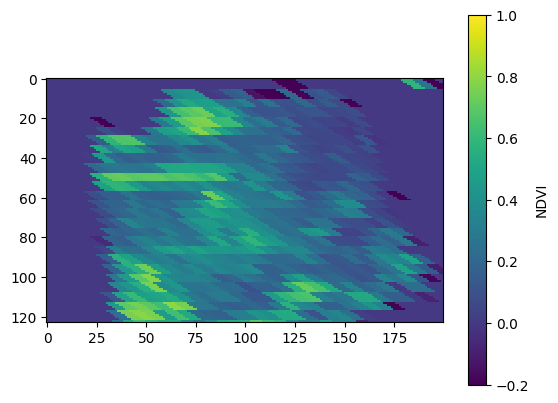

In [99]:
import matplotlib.colors as mcolors

plt.imshow(vals, vmin=-0.2, vmax=1, cmap='viridis', interpolation='nearest')
plt.colorbar(label='NDVI')
plt.show()

## Image retrieval functions

This section has a function to get a 1000x1000 meter patch of pixels from an asset, centered on the provided coordinates, as a numpy array.  The function can be retried automatically by using the [Retry](https://googleapis.dev/python/google-api-core/latest/retry.html) decorator.  There is also a function to serialize a structured array to a `tf.Example` proto.

In [52]:
import pyproj
import numpy as np
modis_data = np.array(vals)
# Define source and target projections
source_crs = 'SR-ORG:6974'  # MODIS Sinusoidal
target_crs = 'EPSG:4326'  # Geographic (WGS 84)

# Create pyproj transformer
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Assuming 'modis_data' is your NumPy array containing the MODIS data
height, width = modis_data.shape

# Get the pixel resolution (assuming it's constant)
# You might need to adjust this based on your MODIS data metadata
pixel_size = 250  # Example: 250 meters

# Create arrays of x and y coordinates in the source projection
x_coords = np.arange(0, width) * pixel_size
y_coords = np.arange(0, height) * pixel_size

# Create a grid of coordinates
xx, yy = np.meshgrid(x_coords, y_coords)

# Transform the coordinates to the target projection
lon, lat = transformer.transform(xx, yy)

# Now you have 'lon' and 'lat' arrays representing the reprojected coordinates
# You can use these to plot the data or further process it

# Example: plot the reprojected data using matplotlib
import matplotlib.pyplot as plt
plt.imshow(modis_data, extent=[lon.min(), lon.max(), lat.min(), lat.max()])
plt.show()

CRSError: Invalid projection: SR-ORG:6974: (Internal Proj Error: proj_create: crs not found: SR-ORG:6974)

In [ ]:
@retry.Retry()
def get_patch(coords, asset_id, band):
  """Get a patch of pixels from an asset, centered on the coords."""
  point = ee.Geometry.Point(coords)
  request = {
    'fileFormat': 'NPY',
    'bandIds': [band],
    'region': point.buffer(1000).bounds().getInfo(),
    'assetId': asset_id
  }
  return np.load(io.BytesIO(ee.data.getPixels(request)))[band]


def _float_feature(floats):
  """Returns a float_list from a float list."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=floats))


def array_to_example(struct_array):
  """"Serialize a structured numpy array into a tf.Example proto."""
  struct_names = struct_array.dtype.names
  feature = {}
  shape = np.shape(struct_array[struct_names[0]])
  feature['h'] = _float_feature([shape[1]])
  feature['w'] = _float_feature([shape[2]])
  for f in struct_names:
    feature[f] = _float_feature(struct_array[f].flatten())
  return tf.train.Example(
      features = tf.train.Features(feature = feature))

# Get patches from the images

In the variable declarations, there's a random sample in an arbitrary region of interest and a year range.  At each point in the sample, in each year, in each 16-day composite, get a patch.  The patch extraction is handled in multiple threads using a `ThreadPoolExecutor`.  Write into TFRecords where each record stores all patches for a (point, year) combination.

In [1]:
executor = concurrent.futures.ThreadPoolExecutor(max_workers=200)

writer = tf.io.TFRecordWriter(OUTPUT_FILE, 'GZIP')

for point in tqdm(SAMPLE):
  for year in tqdm(YEARS):
    year = int(year)
    images = MOD13Q1.filter(
        ee.Filter.calendarRange(year, year, 'year')).getInfo()['features']

    future_to_image = {
        executor.submit(get_patch, point['coordinates'], image['id'], 'NDVI'):
            image['id'] for image in images
    }

    arrays = ()
    types = []
    for future in concurrent.futures.as_completed(future_to_image):
      image_id = future_to_image[future]
      image_name = image_id.split('/')[-1]
      try:
          np_array = future.result()
          arrays += (np_array,)
          types.append((image_name, np.int_, np_array.shape))
      except Exception as e:
          print(e)
          pass
    array = np.array([arrays], types)
    example_proto = array_to_example(array)
    writer.write(example_proto.SerializeToString())
    writer.flush()

writer.close()

NameError: name 'concurrent' is not defined

## Inspect the written files

The parsing function dynamically determines the shape and keys of each record, which may vary by point and year.  Once the data are parsed, they can be displayed as an animation: one year's worth of NDVI change in a patch centered on the point.

In [ ]:
h_col = tf.io.FixedLenFeature(shape=(1), dtype=tf.float32)
w_col = tf.io.FixedLenFeature(shape=(1), dtype=tf.float32)
hw_dict = {'h': h_col, 'w': w_col}

def parse_tfrecord(example_proto):
  """Parse a serialized example, dynamic determination of shape and keys."""
  hw = tf.io.parse_single_example(example_proto, hw_dict)
  h = int(hw['h'].numpy())
  w = int(hw['w'].numpy())

  example = tf.train.Example()
  example.ParseFromString(example_proto.numpy())
  f_list = list(example.features.feature.keys())
  f_dict = {e: tf.io.FixedLenFeature(shape=(h,w), dtype=tf.float32) for e in f_list if e not in ('h', 'w')}
  return tf.io.parse_single_example(example_proto, f_dict)

In [ ]:
dataset = tf.data.TFRecordDataset(OUTPUT_FILE, compression_type='GZIP')
parsed_data = [parse_tfrecord(rec) for rec in dataset]

### Get an animation of the data in a record

See [this reference](https://matplotlib.org/stable/gallery/animation/dynamic_image.html) for details, including options to save the animation.

In [ ]:
array_dict = parsed_data[400]

fig, ax = plt.subplots()

# This order.
images_names = np.sort(list(array_dict.keys()))
first_image = images_names[0]

ax.imshow(np.squeeze(array_dict[first_image]))  # show an initial one first
ims = []
for image in images_names[1:]:
    im = ax.imshow(np.squeeze(array_dict[image]), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani